# NBA Data Science Proyect

In this  notebook we will perform data analisys on NBA Players & Teams data. The objective will be to find insights on how good performing teams are composed in terms of players profiles.

## Load neccesary libraries & UDFs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import typing

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


In [2]:
#UDF to perform Scaling by a group variable
class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def inverse_transform(self, df):
        return self._call_with_function(df, "inverse_transform")

In [3]:
# Function to plot the ROC curve
def plot_roc(y_test, y_score,y_train, y_score_train):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    # Compute micro-average ROC curve and ROC area
    fpr_train["micro"], tpr_train["micro"], _ = metrics.roc_curve(y_train.ravel(), y_score_train.ravel())
    roc_auc_train["micro"] = metrics.auc(fpr_train["micro"], tpr_train["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot(fpr_train["micro"], tpr_train["micro"], color='green',
             lw=lw, label='Training ROC curve (area = %0.2f)' % roc_auc_train["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Read the data

In [4]:
# We will load the data from the csv file into a pandas dataframe
path = '/Users/pabloserranomolinero/Downloads/archive/'
df = pd.read_csv(path + 'players.csv', delimiter=';',encoding= 'latin-1')
df.head(50)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,...,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991
1,2,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,...,0.5,1.3,1.8,3.1,0.8,0.1,1.6,2.2,14.1,1991
2,3,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,...,2.1,3.2,5.3,0.4,0.4,0.4,0.6,3.2,4.2,1991
3,4,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,...,0.9,3,3.9,10.5,2.2,0.1,3.6,2.5,26.5,1991
4,5,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,...,1.7,3.1,4.8,1.8,0.6,0.3,1.6,2.7,14.2,1991
5,6,Danny Ainge,SG,31,POR,80,0,21.4,4.2,8.9,...,0.6,2,2.6,3.6,0.8,0.2,1.3,2.4,11.1,1991
6,7,Mark Alarie,PF,27,WSB,42,1,14,2.4,5.4,...,1,1.8,2.8,1.1,0.4,0.2,1,2.1,5.8,1991
7,8,Steve Alford,PG,26,DAL,34,0,6.9,1.7,3.4,...,0.3,0.4,0.7,0.6,0.2,0,0.5,0.3,4.4,1991
8,9,Greg Anderson,PF,26,TOT,68,2,13.6,1.7,4,...,1.4,3.3,4.7,0.2,0.5,0.7,1.2,2.1,4.3,1991
9,9,Greg Anderson,PF,26,MIL,26,0,9.5,1,2.8,...,1,1.9,2.9,0.1,0.3,0.3,0.8,1.1,2.7,1991


We see some wrong values in the data, due to wrong cvs appending while creating the dataset. Due to this data is imported as object variables so we will convert them to the correct type. 

To do so we first need to remove wrong values in columns. 

In [5]:
# Remove wrong rows and unnecessary column
df = df[df.Rk != 'Rk'].drop('Rk', axis=1)

# Remove * from players Names
df["Player"].str.replace("*","", regex=False)
df.head(50)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.474,...,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.413,...,0.5,1.3,1.8,3.1,0.8,0.1,1.6,2.2,14.1,1991
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.509,...,2.1,3.2,5.3,0.4,0.4,0.4,0.6,3.2,4.2,1991
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,0.394,...,0.9,3,3.9,10.5,2.2,0.1,3.6,2.5,26.5,1991
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.462,...,1.7,3.1,4.8,1.8,0.6,0.3,1.6,2.7,14.2,1991
5,Danny Ainge,SG,31,POR,80,0,21.4,4.2,8.9,0.472,...,0.6,2,2.6,3.6,0.8,0.2,1.3,2.4,11.1,1991
6,Mark Alarie,PF,27,WSB,42,1,14,2.4,5.4,0.44,...,1,1.8,2.8,1.1,0.4,0.2,1,2.1,5.8,1991
7,Steve Alford,PG,26,DAL,34,0,6.9,1.7,3.4,0.504,...,0.3,0.4,0.7,0.6,0.2,0,0.5,0.3,4.4,1991
8,Greg Anderson,PF,26,TOT,68,2,13.6,1.7,4,0.43,...,1.4,3.3,4.7,0.2,0.5,0.7,1.2,2.1,4.3,1991
9,Greg Anderson,PF,26,MIL,26,0,9.5,1,2.8,0.37,...,1,1.9,2.9,0.1,0.3,0.3,0.8,1.1,2.7,1991


In [6]:
# Data transformation
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='ignore')
df.dtypes

Player     object
Pos        object
Age         int64
Tm         object
G           int64
GS          int64
MP        float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
AST       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
Year        int64
dtype: object

Now that we have the correct columns and variables, we will perform a describe() to get a general idea of the data and its values.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,17386.0,26.831416,4.172764,18.0,24.000,26.000,30.000,44.0
G,17386.0,46.989762,26.344559,1.0,23.000,50.000,72.000,85.0
GS,17386.0,22.334004,27.685642,0.0,0.000,7.000,41.000,83.0
MP,17386.0,19.730571,10.113385,0.0,11.300,18.900,28.000,44.5
FG,17386.0,2.964978,2.160449,0.0,1.300,2.400,4.200,12.7
FGA,17386.0,6.637547,4.564583,0.0,3.100,5.500,9.300,27.8
FG%,17386.0,0.432152,0.105389,0.0,0.396,0.438,0.481,1.0
3P,17386.0,0.527401,0.664068,0.0,0.000,0.200,0.900,5.3
3PA,17386.0,1.521799,1.752609,0.0,0.100,0.900,2.500,13.2
3P%,17386.0,0.232091,0.182534,0.0,0.000,0.289,0.363,1.0


We don't see any weird values in the data, so we can continue with the analysis.

Now we will check the number of missing values.

In [8]:
# Count the number of missing values in each column
df.isnull().sum()/len(df)

Player    0.0
Pos       0.0
Age       0.0
Tm        0.0
G         0.0
GS        0.0
MP        0.0
FG        0.0
FGA       0.0
FG%       0.0
3P        0.0
3PA       0.0
3P%       0.0
2P        0.0
2PA       0.0
2P%       0.0
eFG%      0.0
FT        0.0
FTA       0.0
FT%       0.0
ORB       0.0
DRB       0.0
TRB       0.0
AST       0.0
STL       0.0
BLK       0.0
TOV       0.0
PF        0.0
PTS       0.0
Year      0.0
dtype: float64

We are lucky, there are no missing values in the data.

## Feature Engineering

In this step we will create some new variables that could enrich our analysis. Those metrics are usually used in the NBA to evaluate players performance in more detail.

* **AST_TOV** : Number of assists per turnover
* **TS%** : A shooting percentage that factors in the value of three-point field goals and free throws in addition to conventional two-point field goals
* **FT_RATE** : Number of free throws per field goal attempt
* **ORB%** : Number of offensive rebounds per 100 rebounds
* **hAST** : This divides the number of assists a player has by the number of offensive possessions that end in that player's hands. It is a measure of a player's ability to create shots for himself and others.
* **TOV%** : Percent of a player's possessions that ends in turnovers, essentially the same as the hAST% equation, but for turnovers rather than assists

In [9]:
# Assis to Turnover Ratio
df['AST_TOV'] = np.where(df['TOV'] == 0,0,df['AST'] / df['TOV'])

# True shooting percentage
df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))

# Free throw rate
df['FT_RATE'] = np.where( df['FGA'] == 0,0,df['FTA'] / df['FGA'])

# Offensive rebound percentage
df['ORB%'] = df['ORB'] / (df['ORB'] + df['DRB'])

# Hollinger's assist ratio
df['hAST'] = df['AST'] / (df['FGA'] + 0.44 * df['FTA'] + df['AST'] + df['TOV'])

# Turnover percentage
df['TOV%'] = df['TOV'] / (df['FGA'] + 0.44 * df['FTA'] + df['AST'] + df['TOV'])

# Fill NA Values generated by division by 0
df.fillna(0, inplace=True)

We will perform a describe() for the new columns

In [10]:
# List with the new colums
new = ['TOV%', 'hAST', 'ORB%', 'FT_RATE', 'TS%', 'AST_TOV']

# Describe the new columns
df[new].describe().T


,count,mean,std,min,25%,50%,75%,max
TOV%,17386.0,0.119152,0.058180,0.0,0.091460,0.112520,0.137424,1.0
hAST,17386.0,0.156688,0.094227,0.0,0.092593,0.137776,0.207321,1.0
ORB%,17386.0,0.263432,0.137158,0.0,0.173913,0.260000,0.343750,1.0
FT_RATE,17386.0,0.302802,0.232330,0.0,0.179487,0.268557,0.376295,5.0
TS%,17386.0,0.505707,0.106065,0.0,0.474279,0.519961,0.557103,1.5
AST_TOV,17386.0,1.411845,0.968616,0.0,0.750000,1.250000,1.933333,20.0


# EDA

In this section we will perform some exploratory data analysis to get a better understanding of the data. We will start by checking the distribution of the variables.

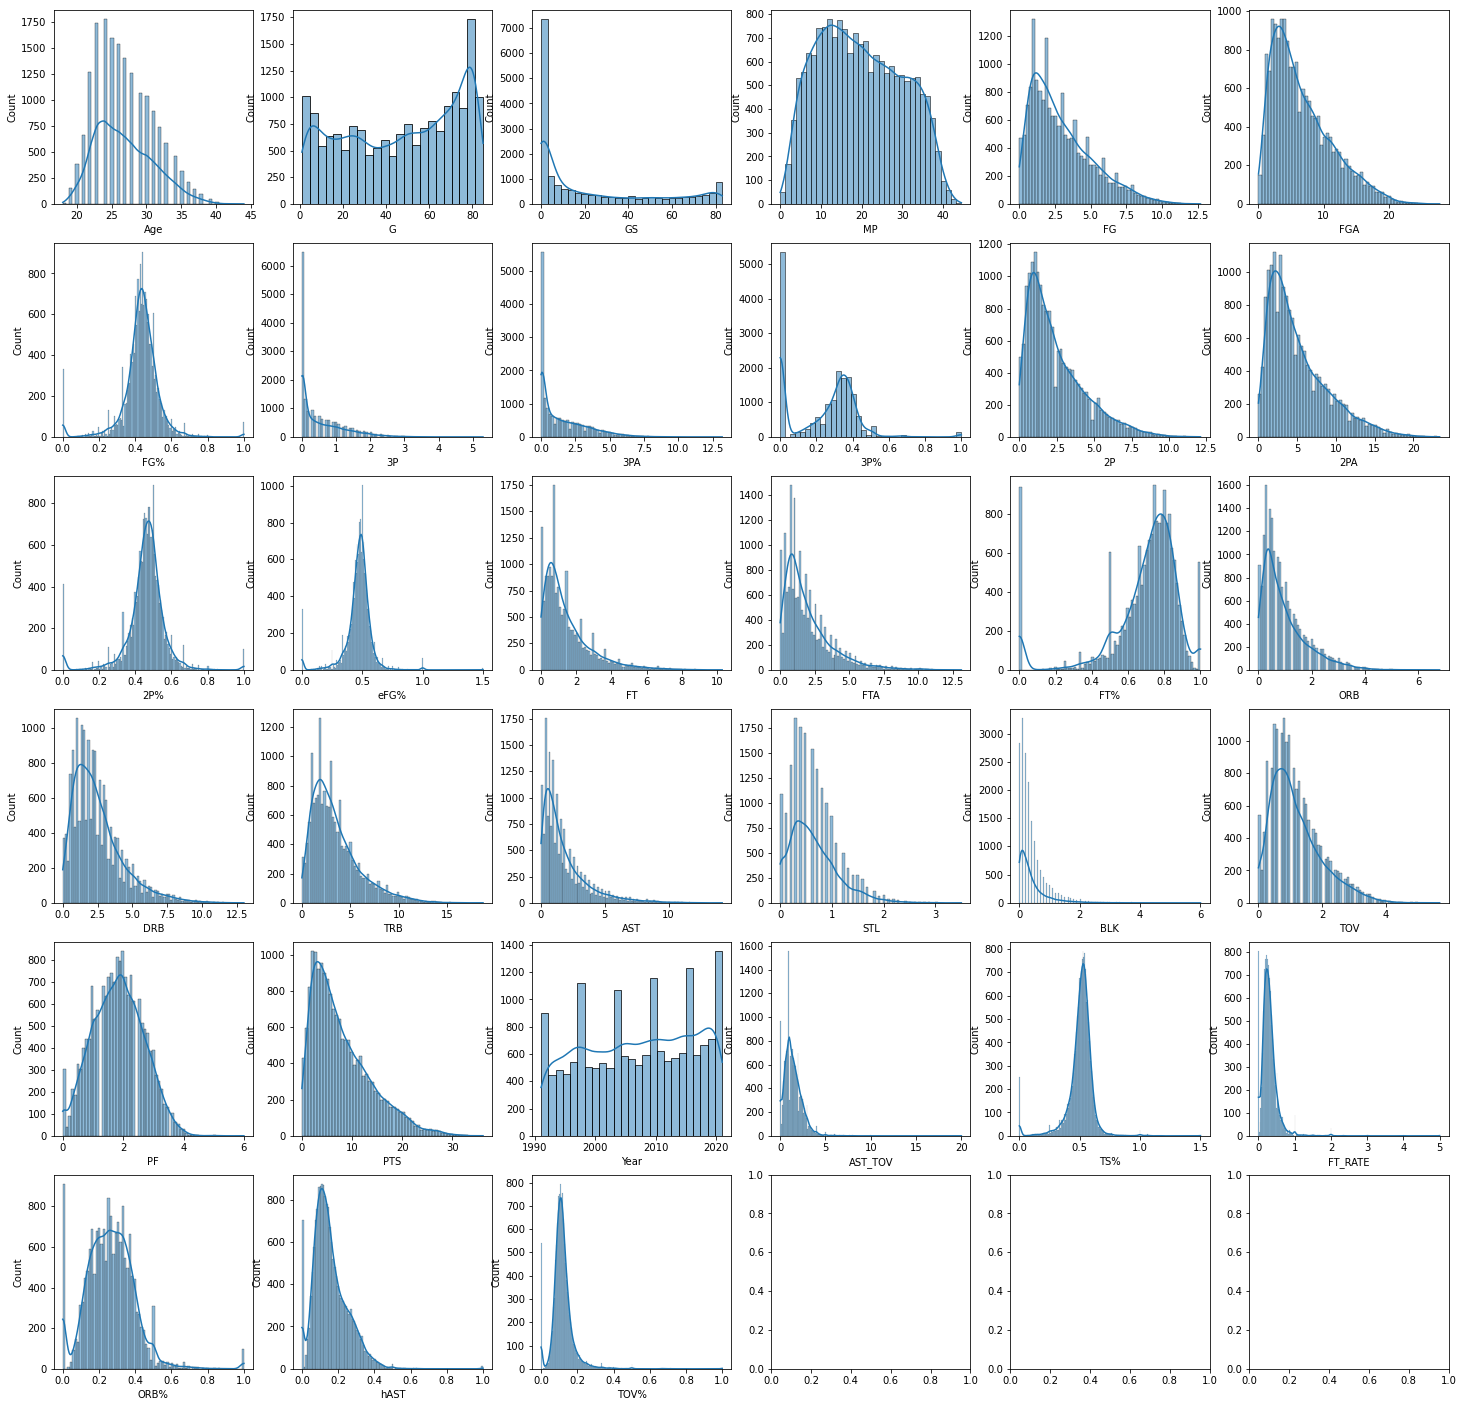

In [11]:
# Define the number of rows and columns you want
n_rows=6
n_cols=6

# Select numerical columns
num = df.select_dtypes(include=['float64', 'int64'])

# Create the subplots
fig, axes = plt.subplots(figsize = (25,25),nrows=n_rows, ncols=n_cols)
for i, column in enumerate(num.columns):
    sns.histplot(num[column],ax=axes[i//n_cols,i%n_cols],kde=True)

We see that some variables like field goals, points or free throws are highly skewed. We will perform a log transformation to get a better distribution for those variables.

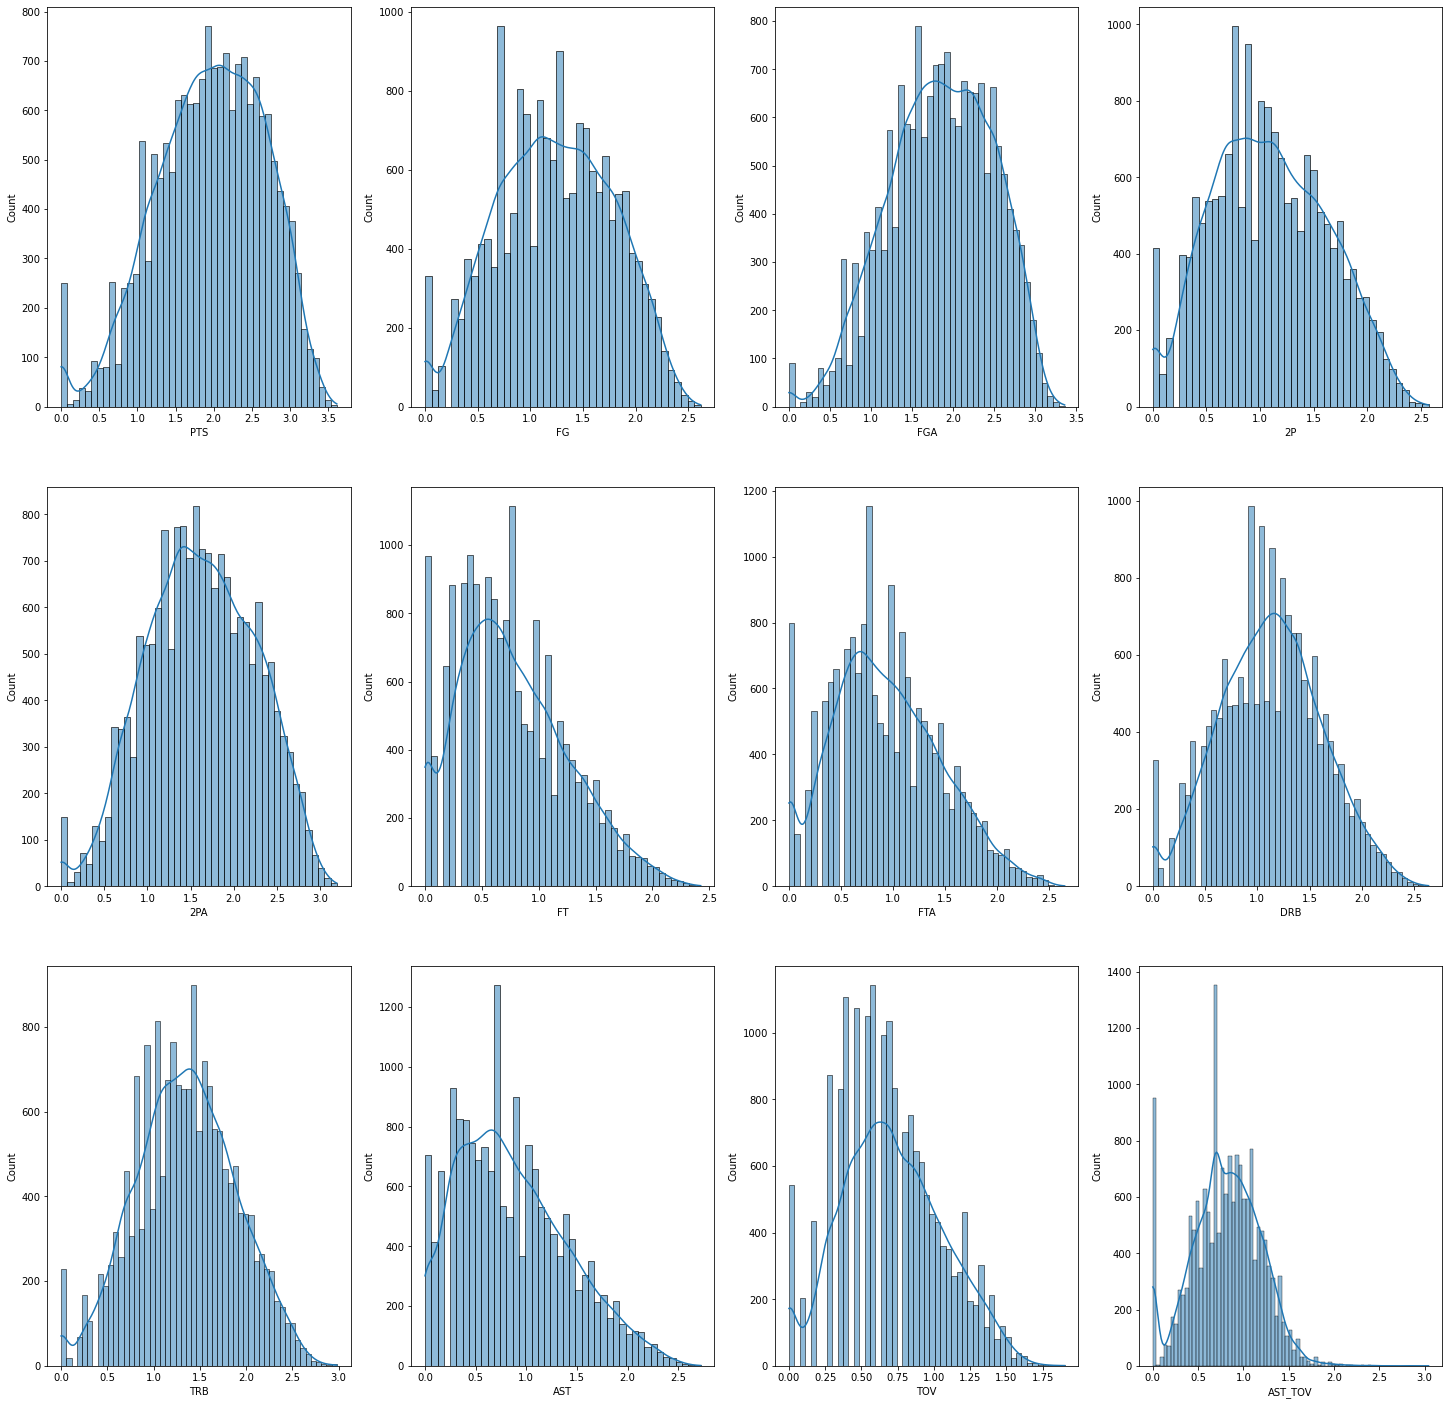

In [12]:
# Define the number of rows and columns you want
n_rows=3
n_cols=4

# Select the columns to apply the log transformation
log = ['PTS','FG','FGA','2P','2PA','FT','FTA','DRB','TRB','AST','TOV','AST_TOV']
# Create the subplots
fig, axes = plt.subplots(figsize = (25,25),nrows=n_rows, ncols=n_cols)
for i, column in enumerate(log):
    sns.histplot(np.log(num[column]+1),ax=axes[i//n_cols,i%n_cols],kde=True)

We see that the distribution of the variables is much better now. We may use this transformation in the future.

## Cluster Analysis

For the clustering to be more reliable, we will scale the data. We will use the MinMaxScaler to scale the data between 0 and 1 but we will perform this by Year, so we scale the changes some variables took over time, for example 3PA. 

We now the number of 3 point attempts has increased over time, so we want to scale the data by year to take this into account. Maybe a good shooting player in 2010 is not a good shooting player in 2019 and we don't want to penalize him for that.

In [13]:
# We will scale all variables to have the same weight in the clustering algorithm
scaler = SklearnWrapper(MinMaxScaler())
features = (
    num.groupby("Year")
    .apply(scaler.fit_transform)
)
features

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,TOV,PF,PTS,Year,AST_TOV,TS%,FT_RATE,ORB%,hAST,TOV%
0,0.062500,0.518519,0.000000,0.122396,0.107438,0.114407,0.474,0.000000,0.000000,0.000,...,0.125,0.204545,0.098413,0.0,0.108434,0.464013,0.178326,0.300000,0.154780,0.296108
1,0.000000,0.814815,0.231707,0.533854,0.512397,0.639831,0.413,0.160000,0.176471,0.240,...,0.400,0.500000,0.447619,0.0,0.350151,0.420495,0.047829,0.277778,0.307996,0.182470
2,0.437500,0.827160,0.000000,0.450521,0.132231,0.131356,0.509,0.000000,0.000000,0.333,...,0.150,0.727273,0.133333,0.0,0.120482,0.525000,0.232975,0.396226,0.170821,0.294118
3,0.437500,0.802469,0.804878,0.872396,0.702479,0.911017,0.394,1.000000,1.000000,0.296,...,0.900,0.568182,0.841270,0.0,0.527108,0.497802,0.179156,0.230769,0.545606,0.214724
4,0.625000,0.950617,0.158537,0.617188,0.446281,0.495763,0.462,0.120000,0.117647,0.308,...,0.400,0.613636,0.450794,0.0,0.203313,0.494224,0.168724,0.354167,0.216457,0.220855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18039,0.428571,0.366197,0.111111,0.670391,0.348214,0.360870,0.462,0.226415,0.244094,0.398,...,0.260,0.275000,0.312500,0.0,0.173077,0.522994,0.039157,0.256410,0.413012,0.094394
18040,0.619048,0.943662,0.319444,0.628492,0.482143,0.421739,0.559,0.037736,0.055118,0.267,...,0.400,0.550000,0.378125,0.0,0.134375,0.537366,0.043814,0.396825,0.405660,0.119417
18041,0.142857,0.873239,0.875000,0.891061,0.687500,0.769565,0.438,0.415094,0.496063,0.343,...,0.820,0.450000,0.790625,0.0,0.143293,0.545299,0.122881,0.153846,0.424004,0.117049
18042,0.428571,0.661972,0.291667,0.533520,0.339286,0.295652,0.559,0.018868,0.047244,0.143,...,0.220,0.625000,0.293750,0.0,0.102273,0.552101,0.091912,0.362319,0.263333,0.101852


In order to select the number of clusters we use the elbow method.

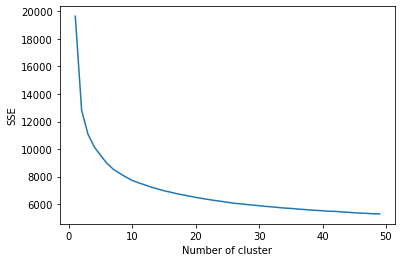

In [14]:
# Fit the model
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000,init='k-means++').fit(features)
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

We select 10 clusters as the optimal number of clusters.

In [15]:
# We will use 10 clusters as the elbow is not very clear
kmeans = KMeans(n_clusters=10, max_iter=1000,init='k-means++').fit(features)

# We will add the cluster id to the original df
df['ClusterID'] = kmeans.labels_

At this point we will create a new variable indicating if the player is new to the team or not.

In [16]:
# Distinct players in the DF
players = df['Player'].unique()
df['NewPlayer'] = 0

# We create a variable that indicates if the player is new to it team or not (1 if it is new, 0 if it is not)
for p in players:
    df.loc[df['Player'] == p,('NewPlayer')] = np.where(df.loc[df['Player'] == p,('Tm')] == df.loc[df['Player'] == p,('Tm')].shift(1),0,1)
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PTS,Year,AST_TOV,TS%,FT_RATE,ORB%,hAST,TOV%,ClusterID,NewPlayer
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.474,...,3.1,1991,0.600000,0.493631,0.370370,0.300000,0.076142,0.126904,7,1
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.413,...,14.1,1991,1.937500,0.447335,0.099338,0.277778,0.151515,0.078201,1,1
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.509,...,4.2,1991,0.666667,0.558511,0.483871,0.396226,0.084034,0.126050,6,1
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,0.394,...,26.5,1991,2.916667,0.529576,0.372093,0.230769,0.268405,0.092025,2,1
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.462,...,14.2,1991,1.125000,0.525770,0.350427,0.354167,0.106484,0.094652,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18039,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,0.462,...,10.0,2021,2.769231,0.563571,0.156627,0.256410,0.261400,0.094394,1,1
18040,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,0.559,...,12.1,2021,2.150000,0.579058,0.175258,0.396825,0.256747,0.119417,5,0
18041,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,0.438,...,25.3,2021,2.292683,0.587607,0.491525,0.153846,0.268357,0.117049,2,0
18042,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.559,...,9.4,2021,1.636364,0.594937,0.367647,0.362319,0.166667,0.101852,5,0


We display the centroids of the clusters ordered by Points per Game.

In [17]:
# We will create a df with the cluster centroids to isnterpret the clusters inferred
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_,columns=num.columns)
cluster_centroids.sort_values(by='PTS',ascending=False)

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,TOV,PF,PTS,Year,AST_TOV,TS%,FT_RATE,ORB%,hAST,TOV%
2,0.360273,0.846845,0.837989,0.887512,0.685491,0.709288,0.463354,0.467745,0.508754,0.347088,...,0.642914,0.556225,0.676561,0.0,0.268422,0.542752,0.136124,0.213721,0.313499,0.169635
4,0.356718,0.845712,0.824042,0.837677,0.647660,0.606438,0.513999,0.061237,0.080087,0.188473,...,0.563958,0.697360,0.599765,0.0,0.159773,0.546315,0.165065,0.292095,0.192886,0.186956
1,0.400972,0.431249,0.194699,0.678949,0.427850,0.462414,0.438487,0.339661,0.380687,0.340958,...,0.399684,0.526661,0.407074,0.0,0.233577,0.505233,0.106177,0.214598,0.281445,0.168478
3,0.398912,0.892685,0.785377,0.755530,0.422289,0.448261,0.449147,0.396121,0.420393,0.355737,...,0.404057,0.527488,0.404341,0.0,0.294950,0.527946,0.100058,0.206909,0.342605,0.169692
5,0.380675,0.823286,0.608414,0.645027,0.359900,0.339325,0.510724,0.024994,0.034890,0.124632,...,0.352408,0.655516,0.323625,0.0,0.137090,0.531214,0.153515,0.337189,0.183970,0.210161
9,0.390224,0.820423,0.174291,0.491819,0.251550,0.275102,0.433541,0.245987,0.270804,0.347828,...,0.245679,0.410963,0.239327,0.0,0.259005,0.512624,0.092830,0.218197,0.306244,0.178658
6,0.372894,0.655637,0.127363,0.386166,0.197389,0.189469,0.500316,0.010252,0.018154,0.082780,...,0.211765,0.504963,0.177086,0.0,0.119078,0.520231,0.161357,0.356820,0.171940,0.225588
0,0.371165,0.371122,0.029804,0.297533,0.141621,0.164377,0.408116,0.130033,0.152413,0.339192,...,0.164541,0.289264,0.133946,0.0,0.262699,0.479327,0.095044,0.216204,0.327448,0.188726
7,0.329463,0.217663,0.010432,0.170440,0.083579,0.091684,0.442113,0.013534,0.028811,0.065355,...,0.116303,0.251610,0.078812,0.0,0.108425,0.479857,0.188321,0.341431,0.166108,0.242480
8,0.347751,0.067281,0.001916,0.128182,0.044522,0.072656,0.234096,0.029689,0.053285,0.101821,...,0.086937,0.165128,0.036322,0.0,0.103823,0.250328,0.052191,0.232945,0.221696,0.219976


We can see how the clusters have different player profiles. Cluster 1 has players with high points per game, cluster 6 has players with high three point percentage, etc.

With this clusters we can see how good performing teams are composed in terms of players profiles.

In [18]:
# Check the number of players in each cluster by team
df[df['Year'] == 2021].groupby(['Tm','Year','ClusterID']).size().unstack().reset_index().fillna(0)

ClusterID,Tm,Year,0,1,2,3,4,5,6,7,8,9
0,ATL,2021,3.0,5.0,1.0,1.0,2.0,0.0,1.0,3.0,0.0,2.0
1,BOS,2021,7.0,1.0,2.0,2.0,0.0,2.0,1.0,2.0,1.0,3.0
2,BRK,2021,5.0,3.0,3.0,1.0,0.0,3.0,1.0,2.0,6.0,3.0
3,CHI,2021,4.0,3.0,1.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0
4,CHO,2021,1.0,1.0,2.0,3.0,0.0,1.0,1.0,3.0,1.0,4.0
5,CLE,2021,6.0,4.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0
6,DAL,2021,3.0,0.0,1.0,3.0,1.0,0.0,3.0,4.0,1.0,3.0
7,DEN,2021,6.0,3.0,1.0,2.0,1.0,0.0,2.0,0.0,2.0,5.0
8,DET,2021,3.0,7.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,3.0
9,GSW,2021,2.0,0.0,1.0,3.0,0.0,1.0,2.0,3.0,1.0,5.0


We will also add to this data the number of new players to the team each season.

In [19]:
# Number of new players to each team
new_players = df.groupby(['Tm','Year']).agg({'NewPlayer': 'sum'}).reset_index()
new_players[new_players['Year'] == 2021]

,Tm,Year,NewPlayer
30,ATL,2021,11
61,BOS,2021,10
70,BRK,2021,18
123,CHI,2021,13
130,CHO,2021,7
161,CLE,2021,16
192,DAL,2021,9
223,DEN,2021,13
254,DET,2021,20
285,GSW,2021,7


To have a better understanding, we will add teams information to the analysis. Now we will load sesonal data for all teams in the nba so we can see how those teams performed and how many players they had in each cluster to find out if there is a correlation between the number of players in each cluster and the team performance.

In [41]:
# Read teams season data to a df
seasons = pd.read_csv(path + 'teams.csv', delimiter=';',encoding= 'latin-1')
seasons.head(10)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,0.683,,111.5,105.7,5.22,1991,Boston Celtics*
1,44,38,0.537,12,105.4,105.6,-0.39,1991,Philadelphia 76ers*
2,39,43,0.476,17,103.1,103.3,-0.43,1991,New York Knicks*
3,30,52,0.366,26,101.4,106.4,-4.84,1991,Washington Bullets
4,26,56,0.317,30,102.9,107.5,-4.53,1991,New Jersey Nets
5,24,58,0.293,32,101.8,107.8,-5.91,1991,Miami Heat
6,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1991,Central Division
7,61,21,0.744,,110,101,8.57,1991,Chicago Bulls*
8,50,32,0.61,11,100.1,96.8,3.08,1991,Detroit Pistons*
9,48,34,0.585,13,106.4,104,2.33,1991,Milwaukee Bucks*


We perform some really basic data cleaning and feature engineering.

In [42]:
# Create PO variable to identify playoff teams
seasons["PO"] = np.where(seasons['Team'].str.contains('\*') ,True,False)

# Remove * from teams Names
seasons["Team"] = seasons["Team"].str.replace("*","", regex=False)

# Remove wrong rows
seasons = seasons[~seasons["W"].str.contains("Division")].copy()

# Transform to numeric
seasons = seasons.apply(pd.to_numeric, errors='ignore')
seasons

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team,PO
0,56,26,0.683,,111.5,105.7,5.22,1991,Boston Celtics,True
1,44,38,0.537,12,105.4,105.6,-0.39,1991,Philadelphia 76ers,True
2,39,43,0.476,17,103.1,103.3,-0.43,1991,New York Knicks,True
3,30,52,0.366,26,101.4,106.4,-4.84,1991,Washington Bullets,False
4,26,56,0.317,30,102.9,107.5,-4.53,1991,New Jersey Nets,False
...,...,...,...,...,...,...,...,...,...,...
1028,42,30,0.583,,112.4,110.2,2.26,2021,Dallas Mavericks,True
1029,38,34,0.528,4,113.3,112.3,1.07,2021,Memphis Grizzlies,True
1030,33,39,0.458,9,111.1,112.8,-1.58,2021,San Antonio Spurs,False
1031,31,41,0.431,11,114.6,114.9,-0.20,2021,New Orleans Pelicans,False


We now need to join the teams data with the players data. We will do this by year and team.

As we can see in one dataset we have team names and in the other we have team abbreviations. We will use a dictionary to map the abbreviations to the names.

To do so we will load a nicknames csv file.

In [43]:
# Read teams season data to a df
names = pd.read_csv(path + 'nicknames.csv', delimiter=';',encoding= 'latin-1')
names.head(10)

,Abbreviation,Name
0,ATL,Atlanta Hawks
1,BRK,Brooklyn Nets
2,BKN,Brooklyn Nets
3,BOS,Boston Celtics
4,CHA,Charlotte Bobcats
5,CHH,Charlotte Hornets
6,CHO,Charlotte Hornets
7,CHI,Chicago Bulls
8,CLE,Cleveland Cavaliers
9,DAL,Dallas Mavericks


We will now join this table with the teams table and later with the players table to have the team name in the players table.

In [44]:
# Join seasons and nicknames by team name
seasons = seasons.merge(names, left_on='Team', right_on='Name', how='left')
seasons.drop('Name', axis=1,inplace = True)
seasons.head(10)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team,PO,Abbreviation
0,56,26,0.683,,111.5,105.7,5.22,1991,Boston Celtics,True,BOS
1,44,38,0.537,12,105.4,105.6,-0.39,1991,Philadelphia 76ers,True,PHI
2,39,43,0.476,17,103.1,103.3,-0.43,1991,New York Knicks,True,NYK
3,30,52,0.366,26,101.4,106.4,-4.84,1991,Washington Bullets,False,WSB
4,26,56,0.317,30,102.9,107.5,-4.53,1991,New Jersey Nets,False,NJN
5,24,58,0.293,32,101.8,107.8,-5.91,1991,Miami Heat,False,MIA
6,61,21,0.744,,110.0,101.0,8.57,1991,Chicago Bulls,True,CHI
7,50,32,0.610,11,100.1,96.8,3.08,1991,Detroit Pistons,True,DET
8,48,34,0.585,13,106.4,104.0,2.33,1991,Milwaukee Bucks,True,MIL
9,43,39,0.524,18,109.8,109.0,0.72,1991,Atlanta Hawks,True,ATL


In [45]:
# We can now join the aggregated data with the number of players in each cluster to the teams data
seasons = seasons.merge(df.groupby(['Tm','Year','ClusterID']).size().unstack().reset_index().fillna(0), left_on=['Abbreviation','Year'], right_on=['Tm','Year'], how='left').dropna()
seasons

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team,PO,...,0,1,2,3,4,5,6,7,8,9
0,56,26,0.683,,111.5,105.7,5.22,1991,Boston Celtics,True,...,2.0,0.0,1.0,1.0,3.0,1.0,2.0,4.0,0.0,1.0
1,44,38,0.537,12,105.4,105.6,-0.39,1991,Philadelphia 76ers,True,...,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,3.0,1.0
2,39,43,0.476,17,103.1,103.3,-0.43,1991,New York Knicks,True,...,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,0.0,3.0
3,30,52,0.366,26,101.4,106.4,-4.84,1991,Washington Bullets,False,...,0.0,1.0,0.0,1.0,2.0,3.0,5.0,2.0,0.0,1.0
4,26,56,0.317,30,102.9,107.5,-4.53,1991,New Jersey Nets,False,...,3.0,1.0,1.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,42,30,0.583,,112.4,110.2,2.26,2021,Dallas Mavericks,True,...,3.0,0.0,1.0,3.0,1.0,0.0,3.0,4.0,1.0,3.0
961,38,34,0.528,4,113.3,112.3,1.07,2021,Memphis Grizzlies,True,...,3.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,4.0
962,33,39,0.458,9,111.1,112.8,-1.58,2021,San Antonio Spurs,False,...,4.0,2.0,1.0,2.0,0.0,1.0,0.0,2.0,1.0,5.0
963,31,41,0.431,11,114.6,114.9,-0.20,2021,New Orleans Pelicans,False,...,4.0,3.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0


In [46]:
# We now add the number of new players to each team
seasons = seasons.merge(new_players, left_on=['Abbreviation','Year'], right_on=['Tm','Year'], how='left').dropna()

# We will create a variable for the number of wins in the previous season
seasons['W/L% -1'] = seasons['W/L%'].shift(1)

# Remove missing values
seasons.dropna(inplace=True)

In [47]:
seasons[seasons['Year'] == 2021].sort_values(by='W/L%',ascending=False)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team,PO,...,3,4,5,6,7,8,9,Tm_y,NewPlayer,W/L% -1
891,52,20,0.722,,116.4,107.2,8.97,2021,Utah Jazz,True,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,UTA,7,0.292
896,51,21,0.708,,115.3,109.5,5.67,2021,Phoenix Suns,True,...,3.0,1.0,0.0,1.0,2.0,1.0,4.0,PHO,9,0.306
876,49,23,0.681,,113.6,108.1,5.28,2021,Philadelphia 76ers,True,...,2.0,2.0,1.0,1.0,4.0,4.0,5.0,PHI,16,0.417
877,48,24,0.667,1,118.6,114.1,4.24,2021,Brooklyn Nets,True,...,1.0,0.0,3.0,1.0,2.0,6.0,3.0,BRK,18,0.681
892,47,25,0.653,5,115.1,110.1,4.82,2021,Denver Nuggets,True,...,2.0,1.0,0.0,2.0,0.0,2.0,5.0,DEN,13,0.722
897,47,25,0.653,4,114.0,107.8,6.02,2021,Los Angeles Clippers,True,...,1.0,0.0,2.0,1.0,2.0,1.0,4.0,LAC,11,0.708
881,46,26,0.639,,120.1,114.2,5.57,2021,Milwaukee Bucks,True,...,3.0,1.0,0.0,1.0,2.0,1.0,3.0,MIL,16,0.375
901,42,30,0.583,,112.4,110.2,2.26,2021,Dallas Mavericks,True,...,3.0,1.0,0.0,3.0,4.0,1.0,3.0,DAL,9,0.431
898,42,30,0.583,9,109.5,106.8,2.77,2021,Los Angeles Lakers,True,...,3.0,1.0,2.0,1.0,2.0,1.0,5.0,LAL,9,0.653
893,42,30,0.583,10,116.1,114.3,1.81,2021,Portland Trail Blazers,True,...,1.0,0.0,2.0,1.0,3.0,1.0,2.0,POR,11,0.653


In [48]:
# Based on the team composition we will try to predict PO clinching
# We will use the number of players in each cluster as features
X = seasons.drop(['W','L','W/L%','GB','PS/G','PA/G','SRS','Year','Team','PO', 'Abbreviation','Tm_x','Tm_y'], axis=1).dropna()
y = seasons['PO'].dropna()

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4321)

In [49]:
%%time
# Parameters for the grid search
param_grid = {
    "loss":["deviance"],
    "learning_rate": np.linspace(0.1, 1, 15),
    "min_samples_split": np.linspace(0.1, 1, 15),
    "min_samples_leaf": [0.25],
    "max_depth":[5,8],
    "n_estimators":[250]
    }

# We fit a Gradient Boosting model with the train data
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# We predict the test data to check the accuracy
print('Champion model parameters : ',grid_search.best_params_)
print('Test Score : ',grid_search.score(X_test, y_test))
print('Train Score : ',grid_search.score(X_train, y_train))

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Champion model parameters :  {'learning_rate': 0.1642857142857143, 'loss': 'deviance', 'max_depth': 5, 'min_samples_leaf': 0.25, 'min_samples_split': 0.6142857142857143, 'n_estimators': 250}
Test Score :  0.8794043435162656
Train Score :  0.8957968957968958
CPU times: user 2.46 s, sys: 239 ms, total: 2.7 s
Wall time: 27.9 s


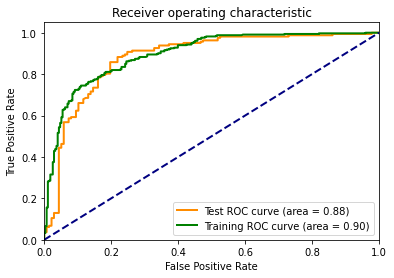

In [50]:
# Plot ROC curve
plot_roc(y_test, grid_search.predict_proba(X_test)[:,1],y_train, grid_search.predict_proba(X_train)[:,1])

<AxesSubplot:>

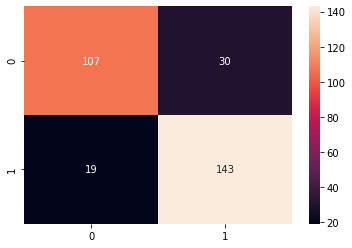

In [51]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, grid_search.predict(X_test)), annot=True, fmt="d")

<AxesSubplot:>

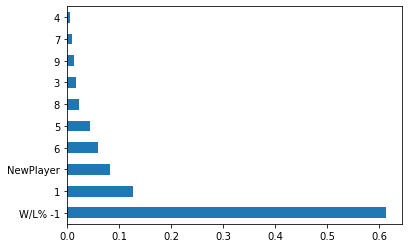

In [52]:
# We plot the feature importance
feat_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')